In [11]:
from collections import Counter
from itertools import chain
import json
import math
from pathlib import Path
from typing import Callable, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataset import DataMaps

In [12]:
def compute_entropy(category_counts):
    """
    Computes the entropy of a category distribution.

    Args:
        category_counts (dict): A dictionary with category names as keys and their counts as values.

    Returns:
        float: The entropy value.
    """
    total = sum(category_counts.values())
    entropy = 0.0

    for count in category_counts.values():
        if count == 0:
            continue
        p_i = count / total
        entropy -= p_i * math.log2(p_i)

    return entropy


def entropy_of_predictions(
    predictions_of_users: list[list[str]],
    category_map: dict[str, str],
    top_k: int = 6,
    *,
    multi_category: bool = False,
):
    """
    Computes the entropy of ranked predictions averaged over multiple users.

    Args:
        predictions_of_users (list[list[str]]): A list of users that each have a list of 
            predicted items as strings.

        category_map (dict[str, str]): A dictionary with the mapping item2category.
            Can be single and multi category.

        top_k (int): The number of highest ranked predictions that are used.

        multi_category (bool): Whether an item (a prediction) has multiple categories.

    Returns:
        float: The average entropy.
    """
    total_entropy = 0

    for user_predicition in predictions_of_users:
        # Only keep the top k predictions
        top_predictions = user_predicition[:top_k]
        # Transform the predicted ids to the actual categories
        categories_of_user_predictions = map(
            lambda item_id: category_map[str(item_id)], top_predictions
        )

        if multi_category:
            categories_of_user_predictions = list(
                chain.from_iterable(categories_of_user_predictions)
            )

        category_counter = Counter(categories_of_user_predictions)
        entropy = compute_entropy(category_counter)
        total_entropy += entropy

    avg_entropy = total_entropy / len(predictions_of_users)

    # TODO: Remove this and put it somewhere else. Not in this function
    print(f"Average Entropy for Top-{top_k} recommendations: {avg_entropy}")
    return avg_entropy

In [13]:
def prediction_str2prediction_list(string: str, sep: str = ", "):
    return string.split(sep)

In [14]:
PROJECT_ROOT = Path()
PREDICTION_DIR = PROJECT_ROOT / "output" / "predictions"
DATA_DIR = PROJECT_ROOT / "data"
CATEGORY_MAP_DIR = DATA_DIR / "category_maps"
DATA_MAP_DIR = DATA_DIR / "self_processed" / "data_maps"
RAW_DATA_DIR = DATA_DIR / "raw"

In [15]:
# All paths to the saved predictions
bsarec_beauty_predictions_path = PREDICTION_DIR / "BSARec_Beauty_best_predictions.csv"
bsarec_ml1m_predictions_path = PREDICTION_DIR / "BSARec_ML-1M_predictions.csv"

sasrec_lastfm_predictions_path = PREDICTION_DIR / "SASRec_LastFM_predictions.csv"
bert4rec_lastfm_predictions_path = PREDICTION_DIR / "BERT4Rec_LastFM_predictions.csv"
duorec_lastfm_predictions_path = PREDICTION_DIR / "DuoRec_LastFM_predictions.csv"
fearec_lastfm_predictions_path = PREDICTION_DIR / "FEARec_LastFM_predictions.csv"
bsarec_lastfm_predictions_path = PREDICTION_DIR / "BSARec_LastFM_predictions.csv"

sasrec_diginetica_predictions_path = PREDICTION_DIR / "SASRec_Diginetica_predictions.csv"
bert4rec_diginetica_predictions_path = PREDICTION_DIR / "BERT4Rec_Diginetica_predictions.csv"
duorec_diginetica_predictions_path = PREDICTION_DIR / "DuoRec_Diginetica_predictions.csv"
fearec_diginetica_predictions_path = PREDICTION_DIR / "FEARec_Diginetica_predictions.csv"
bsarec_diginetica_predictions_path = PREDICTION_DIR / "BSARec_Diginetica_predictions.csv"

In [16]:
# The paths to the category maps e.g. "artist 1" -> "Rock"
lastfm_category_map_path = CATEGORY_MAP_DIR / "LastFM" / "artist_category_mapping.json"
lastfm_popularity_map_path = CATEGORY_MAP_DIR / "LastFM" / "artist_popularity_mapping.json"

ml1m_category_map_path = CATEGORY_MAP_DIR / "ml-1m" / "movie_category_mapping.json"

diginetica_category_map_path = CATEGORY_MAP_DIR / "Diginetica" / "product_category_mapping.json"
diginetica_popularity_map_path = CATEGORY_MAP_DIR / "Diginetica" / "product_popularity_mapping.json"

def load_category_map(path: Path):
    """Load a category map from a path.
    
    Returns a dict with the mapping from item2category. Can be single and multiple categories.
    """
    with path.open("r", newline="", encoding="utf-8") as file:
        return json.load(file)

In [17]:
# The data maps are the user2id, id2user, item2id, id2item for each dataset
beauty_data_maps_path = DATA_MAP_DIR / "Beauty_maps.json"
ml1m_data_maps_path = DATA_MAP_DIR / "ML-1M_maps.json"
lastfm_data_maps_path = DATA_MAP_DIR / "LastFM_maps.json"    
diginetica_data_maps_path = DATA_MAP_DIR / "Diginetica_maps.json"

In [18]:
def load_predictions(prediction_path: Path, prediction_id2item_id: Callable) -> list[list[Union[str, int]]]:
    users_item_id_predictions = pd.read_csv(prediction_path)
    users_item_id_predictions["item_id_predictions"] = users_item_id_predictions["item_id_predictions"].apply(prediction_str2prediction_list)
    item_predictions = users_item_id_predictions["item_id_predictions"].apply(lambda sequence: list(map(prediction_id2item_id, sequence)))
    return list(item_predictions)

def load_user_and_predictions(prediction_path: Path) -> dict[int, list]:
    users_item_id_predictions = pd.read_csv(prediction_path)
    # Transform the prediction from 1 string to a list of predicted items
    users_item_id_predictions["item_id_predictions"] = users_item_id_predictions["item_id_predictions"].apply(prediction_str2prediction_list)
    # Transform items in the list from string to int
    users_item_id_predictions["item_id_predictions"] = users_item_id_predictions["item_id_predictions"].apply(lambda x: [int(item) for item in x])
    return {row.user_id: row.item_id_predictions for row in users_item_id_predictions.itertuples()}

### Dataset: LastFM

In [19]:
# Load LastFM data maps
lastfm_data_maps = DataMaps.read_json(lastfm_data_maps_path)

# Load lastfm artist -> genre map
artist_category_map = load_category_map(lastfm_category_map_path)
# Load lastfm artist -> popularity map
artist_popularity_map = load_category_map(lastfm_popularity_map_path)

# Load predictions from specific models
sasrec_artist_id_predictions = load_predictions(sasrec_lastfm_predictions_path, lastfm_data_maps.id2item)
bert4rec_artist_id_predictions = load_predictions(bert4rec_lastfm_predictions_path, lastfm_data_maps.id2item)
duorec_artist_id_predictions = load_predictions(duorec_lastfm_predictions_path, lastfm_data_maps.id2item)
fearec_artist_id_predictions = load_predictions(fearec_lastfm_predictions_path, lastfm_data_maps.id2item)
bsarec_artist_id_predictions = load_predictions(bsarec_lastfm_predictions_path, lastfm_data_maps.id2item)


#### Entropy for genres

In [20]:
print("SASRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(sasrec_artist_id_predictions, artist_category_map)
print("BERT4Rec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bert4rec_artist_id_predictions, artist_category_map)
print("DuoRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(duorec_artist_id_predictions, artist_category_map)
print("FEARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(fearec_artist_id_predictions, artist_category_map)
print("BSARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bsarec_artist_id_predictions, artist_category_map)

SASRec  : Average Entropy for Top-6 recommendations: 1.2670683863614731
BERT4Rec: Average Entropy for Top-6 recommendations: 1.1072985660877441
DuoRec  : Average Entropy for Top-6 recommendations: 1.253751216741057
FEARec  : Average Entropy for Top-6 recommendations: 1.1707431976214442
BSARec  : Average Entropy for Top-6 recommendations: 1.2099782541054578


#### Entropy for popularity

In [21]:
print("SASRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(sasrec_artist_id_predictions, artist_popularity_map)
print("BERT4Rec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bert4rec_artist_id_predictions, artist_popularity_map)
print("DuoRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(duorec_artist_id_predictions, artist_popularity_map)
print("FEARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(fearec_artist_id_predictions, artist_popularity_map)
print("BSARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bsarec_artist_id_predictions, artist_popularity_map)

SASRec  : Average Entropy for Top-6 recommendations: 0.2992227789817737
BERT4Rec: Average Entropy for Top-6 recommendations: 0.3027601122329626
DuoRec  : Average Entropy for Top-6 recommendations: 0.31432314029948505
FEARec  : Average Entropy for Top-6 recommendations: 0.0
BSARec  : Average Entropy for Top-6 recommendations: 0.4110179137380286


### Dataset: ML-1M

In [22]:
# Load ML-1M data maps
ml1m_data_maps = DataMaps.read_json(ml1m_data_maps_path)

# Load ML-1M movie -> genres map
movie_category_map = load_category_map(ml1m_category_map_path)


# Load predictions from specific models
sasrec_movie_id_predictions = ...
bert4rec_movie_id_predictions = ...
duorec_movie_id_predictions = ...
fearec_movie_id_predictions = ...
bsarec_movie_id_predictions = load_predictions(bsarec_ml1m_predictions_path, ml1m_data_maps.id2item)

#### Entropy for movie categories

In [23]:
_ = entropy_of_predictions(bsarec_movie_id_predictions, movie_category_map, multi_category=True)

Average Entropy for Top-6 recommendations: 2.0451340462138994


### Dataset: Diginetica

In [24]:
# Load Diginetica data maps
diginetica_data_maps = DataMaps.read_json(diginetica_data_maps_path)

# Load Diginetica product-category map
diginetica_category_map = load_category_map(diginetica_category_map_path)
# Load Diginetica product-popularity map
diginetica_popularity_map = load_category_map(diginetica_popularity_map_path)


# Load predictions from specific models
sasrec_diginetica_predictions = load_predictions(sasrec_diginetica_predictions_path, diginetica_data_maps.id2item)
bert4rec_diginetica_predictions = load_predictions(bert4rec_diginetica_predictions_path, diginetica_data_maps.id2item)
duorec_diginetica_predictions = load_predictions(duorec_diginetica_predictions_path, diginetica_data_maps.id2item)
fearec_diginetica_predictions = load_predictions(fearec_diginetica_predictions_path, diginetica_data_maps.id2item)
bsarec_diginetica_predictions = load_predictions(bsarec_diginetica_predictions_path, diginetica_data_maps.id2item)

#### Entropy for product categories

In [25]:
print("SASRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(sasrec_diginetica_predictions, diginetica_category_map)
print("BERT4Rec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bert4rec_diginetica_predictions, diginetica_category_map)
print("DuoRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(duorec_diginetica_predictions, diginetica_category_map)
print("FEARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(fearec_diginetica_predictions, diginetica_category_map)
print("BSARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bsarec_diginetica_predictions, diginetica_category_map)

SASRec  : Average Entropy for Top-6 recommendations: 0.25902111779595344
BERT4Rec: Average Entropy for Top-6 recommendations: 0.2780391710104607
DuoRec  : Average Entropy for Top-6 recommendations: 0.17680181674497952
FEARec  : Average Entropy for Top-6 recommendations: 0.17924620220674636
BSARec  : Average Entropy for Top-6 recommendations: 0.17989211410186284


#### Entropy for product popularity

In [26]:
print("SASRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(sasrec_diginetica_predictions, diginetica_popularity_map)
print("BERT4Rec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bert4rec_diginetica_predictions, diginetica_popularity_map)
print("DuoRec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(duorec_diginetica_predictions, diginetica_popularity_map)
print("FEARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(fearec_diginetica_predictions, diginetica_popularity_map)
print("BSARec".ljust(8) + ": ", end="")
_ = entropy_of_predictions(bsarec_diginetica_predictions, diginetica_popularity_map)

SASRec  : 

Average Entropy for Top-6 recommendations: 0.03719206026774097
BERT4Rec: Average Entropy for Top-6 recommendations: 0.06733702983596924
DuoRec  : Average Entropy for Top-6 recommendations: 0.057751826756835316
FEARec  : Average Entropy for Top-6 recommendations: 0.06913320587150608
BSARec  : Average Entropy for Top-6 recommendations: 0.06626068329660079


## Fairness

In [27]:
class RankBiasedPrecision:
    def __init__(self, patience: float = 0.5):
        self.patience = patience

    def exposure(self, position: int) -> float:
        return self.patience ** position

    def ideal(self, number_of_recommendations: int):
        m = number_of_recommendations
        num = 1 - self.patience ** m
        den = m * (1 - self.patience)
        return np.full(m, num/den)


class Cascade:
    def __init__(self, patience: float = 0.5, stop_prob: float = 0.5):
        self.patience = patience
        self.stop_prob = stop_prob
    
    def exposure(self, positions: np.ndarray, item_rating: np.ndarray) -> float:
        left = self.patience ** positions
        right = 1 - (item_rating * self.stop_prob)
        exposure = left * right.cumprod()
        return exposure
    
    def ideal(self, number_of_recommendations: int):
        m = number_of_recommendations
        num = 1 - self.patience ** m * (1 - self.stop_prob) ** m
        den = m * (1 - self.patience * (1 - self.stop_prob))
        return np.full(m, num / den)

In [28]:
rbp = RankBiasedPrecision()
cascade = Cascade()

In [29]:
def load_raw_diginetica() -> pd.DataFrame:
    data_path = RAW_DATA_DIR / "Diginetica" / "diginetica_train.csv"
    df = pd.read_csv(data_path, delimiter=";", header=0, names=["userId", "itemId", "timeframe", "eventdate"])

    # Drop all users which are nan
    df = df.dropna(subset=["userId", "itemId", "timeframe", "eventdate"])
    
    return df

def load_preprocessed_dataset(data_path: Path) -> dict[int, list[int]]:
    data = {}
    with data_path.open("r", encoding="utf-8", newline="") as file:
        for line in file:
            user, items = line.split(" ", maxsplit=1)
            user = int(user)
            items = items.split(" ")
            items = list(map(lambda item: int(item.strip()), items))
            assert user not in data, "User should not exist twice in the dictionary"
            data[user] = items
    return data

In [30]:
lastfm = load_preprocessed_dataset(DATA_DIR / "LastFM.txt")
diginetica = load_preprocessed_dataset(DATA_DIR / "self_processed" / "Diginetica.txt")

sasrec_lastfm_user_and_predictions = load_user_and_predictions(sasrec_lastfm_predictions_path)
bert4rec_lastfm_user_and_predictions = load_user_and_predictions(bert4rec_lastfm_predictions_path)
duorec_lastfm_user_and_predictions = load_user_and_predictions(duorec_lastfm_predictions_path)
fearec_lastfm_user_and_predictions = load_user_and_predictions(fearec_lastfm_predictions_path)
bsarec_lastfm_user_and_predictions = load_user_and_predictions(bsarec_lastfm_predictions_path)

sasrec_diginetica_user_and_predictions = load_user_and_predictions(sasrec_diginetica_predictions_path)
bert4rec_diginetica_user_and_predictions = load_user_and_predictions(bert4rec_diginetica_predictions_path)
duorec_diginetica_user_and_predictions = load_user_and_predictions(duorec_diginetica_predictions_path)
fearec_diginetica_user_and_predictions = load_user_and_predictions(fearec_diginetica_predictions_path)
bsarec_diginetica_user_and_predictions = load_user_and_predictions(bsarec_diginetica_predictions_path)


In [31]:
class ExposureFairness:
    def __init__(self, user_and_predictions: dict[int, list[int]]):
        self.user_and_predictions = user_and_predictions

    def group_exposure(self, category_map: dict[str, str], dataset, id2item) -> dict[str, float]:
        """Calculate the exposure per group user cascade attention."""
        categories = set(category_map.values())
        exposure_per_group = dict.fromkeys(categories, 0)

        # Go through the users
        for user, predictions in self.user_and_predictions.items():
            # User id in predictions start at 0. User id in datasets start a 1
            user += 1
            ratings = []
            ranks = []
            user_final_item = dataset[user][-1]

            # Go over each item of the top-k recommendations
            for rank, item in enumerate(predictions):
                # The rank is the position of the item in the top-k
                ranks.append(rank)
                # The rating of an item corresponds to whether the predicted item is correct
                rating = 1 if item == user_final_item else 0
                ratings.append(rating)

            # Calculate the exposure of each recommendation
            exposures = cascade.exposure(np.array(ranks), np.array(ratings))
            # Assign the exposure of an item to its corresponding group
            for item, exposure in zip(predictions, exposures):
                real_item_id = id2item(str(item))
                item_category = category_map[str(real_item_id)]
                exposure_per_group[item_category] += exposure
        
        # Average the exposure of the number of users
        for group, exposure in exposure_per_group.items():
            exposure_per_group[group] = exposure / user

        return exposure_per_group
    
    def ideal_group_exposure(self, category_map: dict[str, str], dataset, id2item) -> dict[str, float]:
        categories = set(category_map.values())
        exposure_per_group = dict.fromkeys(categories, 0)

        for user, predictions in dataset.items():
            # User the sequence except for the last two items to use only training data.
            # The second to last item is the validation target. The last is the test target.
            predictions = predictions[:-2]

            ideal_exposure = cascade.ideal(len(predictions))
            for item, exposure in zip(predictions, ideal_exposure):
                real_item_id = id2item(str(item))
                item_category = category_map[str(real_item_id)]
                exposure_per_group[item_category] += exposure
        
        # Average the exposure of the number of users
        for group, exposure in exposure_per_group.items():
            exposure_per_group[group] = exposure / user
        
        return exposure_per_group


    def eed(self, category_map: dict[str, str], dataset, id2item) -> float:
        exposure = self.group_exposure(category_map, dataset, id2item)
        exposure = np.array(list(exposure.values()))
        exposure_distribution = np.sum(exposure ** 2)
        return exposure_distribution
    
    def eel(self, category_map: dict[str, str], dataset, id2item) -> float:
        exposure = self.group_exposure(category_map, dataset, id2item)
        exposure = np.array(list(exposure.values()))

        ideal_exposure = self.ideal_group_exposure(category_map, dataset, id2item)
        ideal_exposure = np.array(list(ideal_exposure.values()))
        
        exposure_difference = exposure - ideal_exposure
        return np.sum(exposure_difference ** 2)
    
    def eer(self, category_map: dict[str, str], dataset, id2item) -> float:
        exposure = self.group_exposure(category_map, dataset, id2item)
        exposure = np.array(list(exposure.values()))

        ideal_exposure = self.ideal_group_exposure(category_map, dataset, id2item)
        ideal_exposure = np.array(list(ideal_exposure.values()))
        
        return 2 * np.dot(exposure, ideal_exposure)

        

In [32]:
names = ["SASRec", "BERT4Rec", "DuoRec", "FEARec", "BSARec"]

In [33]:
class VisualFairnessResults:
    def __init__(self, fairness_results: pd.DataFrame):
        self.fairness_results = fairness_results
    
    def single_plot(self):
        df = self.fairness_results.set_index('model')

        # Plot grouped bars
        ax = df.plot(kind='bar', figsize=(10, 6), width=0.75)
        plt.title('Fairness Metrics by Model')
        plt.ylabel('Metric Value')
        plt.xticks(rotation=45)
        plt.legend(title='Metric')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    
    def metric_subplots(self):
        metrics = ['EED', 'EEL', 'EER']

        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

        for i, metric in enumerate(metrics):
            axes[i].bar(self.fairness_results['model'], self.fairness_results[metric], color='skyblue')
            axes[i].set_title(metric)
            axes[i].set_ylabel('Value')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(axis='y', linestyle='--', alpha=0.6)

        fig.suptitle('Fairness Metrics by Model')
        plt.tight_layout()
        plt.show()



,model,EED,EEL,EER
0,SASRec,0.802175,0.092181,1.067289
1,BERT4Rec,0.813297,0.107303,1.063290
2,DuoRec,0.782381,0.083815,1.055862
3,FEARec,3.099744,2.381373,1.075666
4,BSARec,0.736664,0.069293,1.024667


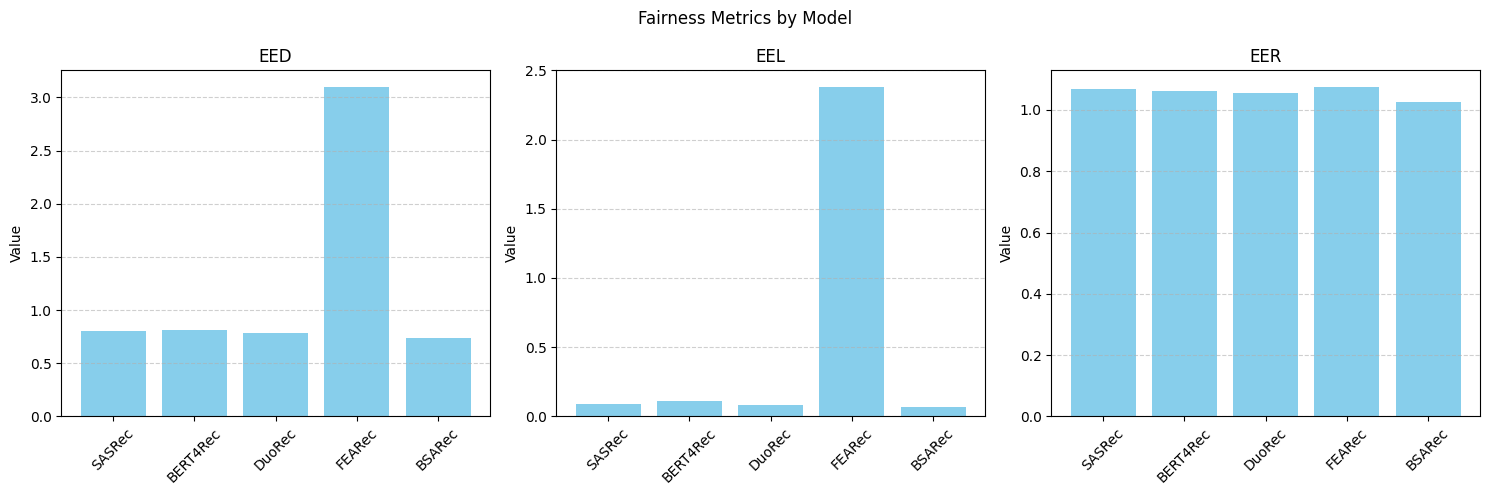

In [34]:
sasrec_artist_fairness = ExposureFairness(sasrec_lastfm_user_and_predictions)
bert4rec_artist_fairness = ExposureFairness(bert4rec_lastfm_user_and_predictions)
duorec_artist_fairness = ExposureFairness(duorec_lastfm_user_and_predictions)
fearec_artist_fairness = ExposureFairness(fearec_lastfm_user_and_predictions)
bsarec_artist_fairness = ExposureFairness(bsarec_lastfm_user_and_predictions)

artist_recommend_exposure = [
    sasrec_artist_fairness,
    bert4rec_artist_fairness,
    duorec_artist_fairness,
    fearec_artist_fairness,
    bsarec_artist_fairness,
]

lastfm_eed = []
lastfm_eel = []
lastfm_eer = []
for model in artist_recommend_exposure:
    eed = model.eed(artist_category_map, lastfm, lastfm_data_maps.id2item)
    lastfm_eed.append(eed)

    eel = model.eel(artist_category_map, lastfm, lastfm_data_maps.id2item)
    lastfm_eel.append(eel)

    eer = model.eer(artist_category_map, lastfm, lastfm_data_maps.id2item)
    lastfm_eer.append(eer)
    
lastfm_fairness_data = {
    "model": names,
    "EED": lastfm_eed,
    "EEL": lastfm_eel,
    "EER": lastfm_eer,
}
lastfm_fairness = pd.DataFrame(lastfm_fairness_data)
display(lastfm_fairness)

lastfm_visual_results = VisualFairnessResults(lastfm_fairness)
lastfm_visual_results.metric_subplots()

,model,EED,EEL,EER
0,SASRec,0.077931,0.009433,0.101992
1,BERT4Rec,0.074954,0.008384,0.100064
2,DuoRec,0.073232,0.007790,0.098936
3,FEARec,0.072185,0.007455,0.098224
4,BSARec,0.072232,0.007455,0.098271


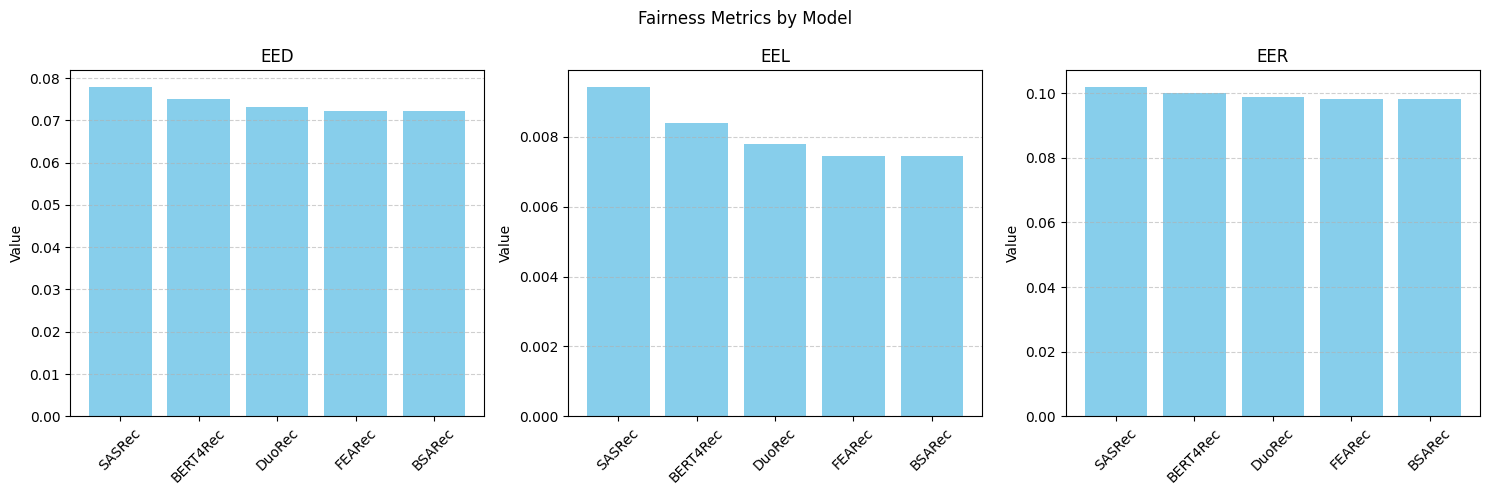

In [35]:
sasrec_diginetica_fairness = ExposureFairness(sasrec_diginetica_user_and_predictions)
bert4rec_diginetica_fairness = ExposureFairness(bert4rec_diginetica_user_and_predictions)
duorec_diginetica_fairness = ExposureFairness(duorec_diginetica_user_and_predictions)
fearec_diginetica_fairness = ExposureFairness(fearec_diginetica_user_and_predictions)
bsarec_diginetica_fairness = ExposureFairness(bsarec_diginetica_user_and_predictions)

diginetica_recommend_exposure = [
    sasrec_diginetica_fairness,
    bert4rec_diginetica_fairness,
    duorec_diginetica_fairness,
    fearec_diginetica_fairness,
    bsarec_diginetica_fairness,
]

diginetica_eed = []
diginetica_eel = []
diginetica_eer = []
for model in diginetica_recommend_exposure:
    eed = model.eed(diginetica_category_map, diginetica, diginetica_data_maps.id2item)
    diginetica_eed.append(eed)

    eel = model.eel(diginetica_category_map, diginetica, diginetica_data_maps.id2item)
    diginetica_eel.append(eel)

    eer = model.eer(diginetica_category_map, diginetica, diginetica_data_maps.id2item)
    diginetica_eer.append(eer)
    
diginetica_fairness_data = {
    "model": names,
    "EED": diginetica_eed,
    "EEL": diginetica_eel,
    "EER": diginetica_eer,
}
diginetica_fairness = pd.DataFrame(diginetica_fairness_data)
display(diginetica_fairness)

diginetica_visual_results = VisualFairnessResults(diginetica_fairness)
diginetica_visual_results.metric_subplots()